Episode 0 / 8000: Total Reward Collected: -79977.52570343018
Episode 500 / 8000: Total Reward Collected: 136.0049867630005
Episode 1000 / 8000: Total Reward Collected: -9827.048765182495
Episode 1500 / 8000: Total Reward Collected: 129.09226989746094
Episode 2000 / 8000: Total Reward Collected: -9872.961090564728
Episode 2500 / 8000: Total Reward Collected: 145.40691757202148
Episode 3000 / 8000: Total Reward Collected: -9794.082990646362
Episode 3500 / 8000: Total Reward Collected: 155.70286774635315
Episode 4000 / 8000: Total Reward Collected: 115.71442222595215
Episode 4500 / 8000: Total Reward Collected: 172.20557236671448
Episode 5000 / 8000: Total Reward Collected: 172.20557236671448
Episode 5500 / 8000: Total Reward Collected: 172.20557236671448
Episode 6000 / 8000: Total Reward Collected: 172.20557236671448
Episode 6500 / 8000: Total Reward Collected: 172.20557236671448
Episode 7000 / 8000: Total Reward Collected: 172.20557236671448
Episode 7500 / 8000: Total Reward Collected: 

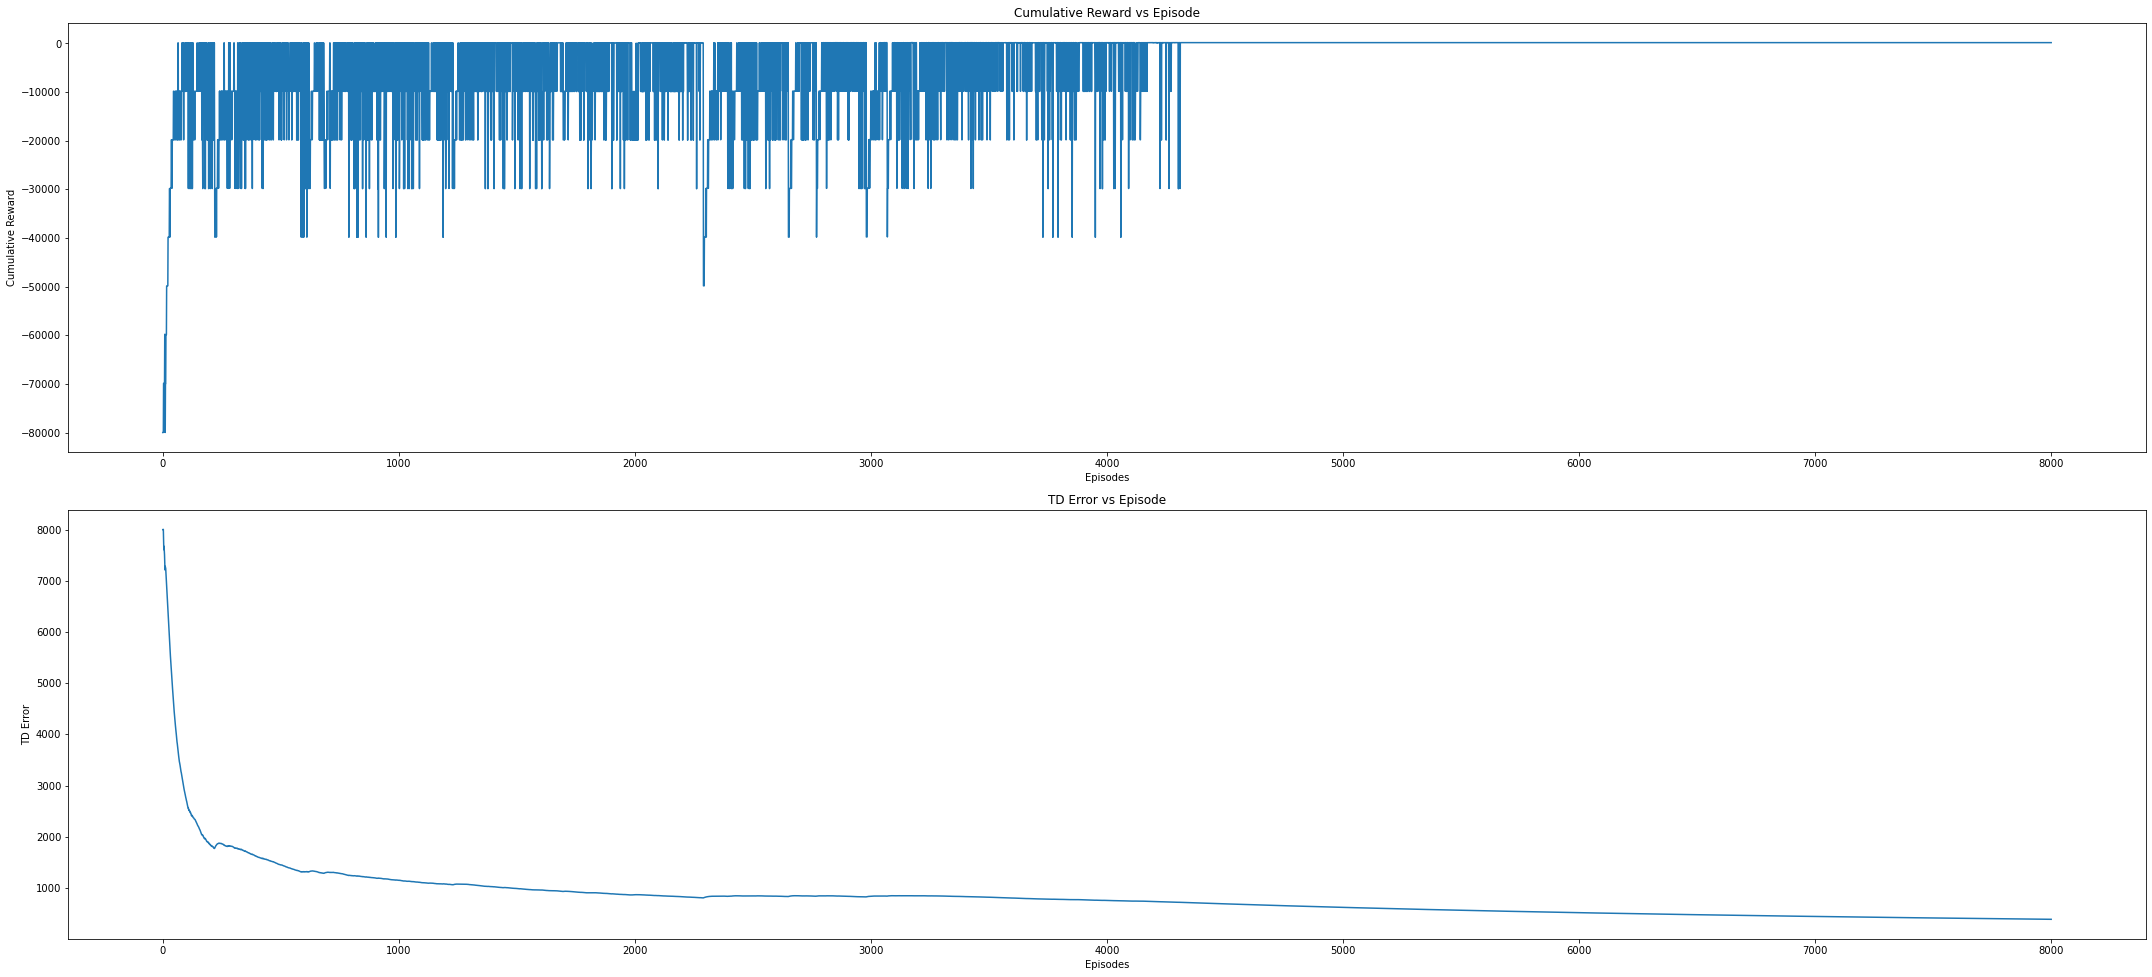

In [19]:
import numpy as np
from numpy import typing as npt
import gymnasium as gym
import matplotlib.pyplot as plt  # Import for plotting
from typing import Dict, List, Optional, Tuple
import pandas as pd

# The TSP Environment Code 
class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)

# Q Learning Code Starts

class QLearning:
    def __init__(self, n_actions, alpha=0.1, gamma=0.99):
        self.n_actions = n_actions 
        self.alpha = alpha 
        self.gamma = gamma  
        self.q_table = {}  
        self.td_errors = [] 

    def choose_action(self, state):
        """Choose the best action based on the current Q-values (greedy policy)."""
        state_str = str(state)
        if state_str not in self.q_table:
            self.q_table[state_str] = np.zeros(self.n_actions)  # Initialize Q-values to 0 if new state
        return np.argmax(self.q_table[state_str])  # This will Always choose the action with the highest Q-value and can be modified to be SARSA

    def update_q_value(self, state, action, reward, next_state):
        """Update the Q-value for the given state-action pair."""
        state_str = str(state)
        next_state_str = str(next_state)

        # If the next State is not in Q Table the just make it 0
        if next_state_str not in self.q_table:
            self.q_table[next_state_str] = np.zeros(self.n_actions)

        # Q-learning update rule
        best_next_action = np.argmax(self.q_table[next_state_str])  # argmax is GREEDY!
        td_target = reward + self.gamma * self.q_table[next_state_str][best_next_action] # Feeding Best Action of s'  as  to get target TD
        td_error = td_target - self.q_table[state_str][action]

        # Abosulte value of TD error is added to self
        self.td_errors.append(abs(td_error))

        # Update Q-value
        self.q_table[state_str][action] += self.alpha * td_error


def main() -> None:
    """Main function to run Q-learning agent in Modified TSP environment."""
    num_targets = 10
    shuffle_time = 10
    num_episodes = 8000

    env = ModTSP(num_targets, shuffle_time=shuffle_time)
    agent = QLearning(n_actions=num_targets)

    ep_rets = []  # This is to Track cumulative rewards
    avg_losses = []  # This is to Track TD error

    for ep in range(num_episodes):
        # init
        state, _ = env.reset()
        done = False 
        total_reward = 0 

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action) # get attribute from Env based on choosen action
            done = terminated or truncated   # end episode if this is true

            agent.update_q_value(state, action, reward, next_state) # calling update_q from agent obj

            total_reward += reward # reward update or cummulitative reward update
            state = next_state # state update

        ep_rets.append(total_reward)
        avg_losses.append(np.mean(agent.td_errors))

        if ep%500 ==0:
            print(f"Episode {ep} / {num_episodes}: Total Reward Collected: {total_reward}")
    print(f"Average reward over {num_episodes} episodes: {np.mean(ep_rets)}")
    
    # Plotting Cumuilative Reward vs Episode
    plt.figure(figsize=(30, 20))
    plt.subplot(3, 1, 1)
    plt.plot(ep_rets)
    plt.title("Cumulative Reward vs Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.savefig("cumulative_reward_vs_episode.png", bbox_inches='tight')

    # Plotting Averge TD Error vs Episode
    plt.subplot(3, 1, 2)
    plt.plot(avg_losses)
    plt.title("TD Error vs Episode")
    plt.xlabel("Episodes")
    plt.ylabel("TD Error")
    plt.savefig("td_error_vs_episode.png", bbox_inches='tight')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()